# extract '.tar'

In [7]:
!tar -xvf ../data.tar.gz

data/
data/meta.csv
data/train/
data/train/e94cb361c4d52900.jpg
data/train/60d372fb5e69fafe.jpg
data/train/fe30845b79d1d42f.jpg
data/train/71dde89e294555fc.jpg
data/train/5da92a313921b370.jpg
data/train/055271bc977c47c7.jpg
data/train/bdf1bd840d1db82c.jpg
data/train/c82156758abf1e7f.jpg
data/train/1ae1f676bdb59f13.jpg
data/train/b85142f970ee0423.jpg
data/train/d78d08f7feeb2225.jpg
data/train/f7a8b8730ac4a993.jpg
data/train/6d5dad8f246c0ecb.jpg
data/train/2e3550bead1a72cb.jpg
data/train/d23b442f24f92dba.jpg
data/train/a9c00da135f7ed8d.jpg
data/train/c4d29037087545be.jpg
data/train/9ae5c389d3485e7d.jpg
data/train/e486affcd2c365ff.jpg
data/train/f66cc08a628bc668.jpg
data/train/382426073dbdd709.jpg
data/train/162759419a76edff.jpg
data/train/2e9848b9a0ccbf72.jpg
data/train/659919452b57f180.jpg
data/train/485508cdbc358c78.jpg
data/train/b141a5c55d387a8a.jpg
data/train/4f251e4f50e1b033.jpg
data/train/9d26b080a59303cd.jpg
data/train/0bb6c060183cddb9.jpg
data/train/48675735fa816fb9.jpg
data/tra

# import Library

In [1]:
import os
import time
import random
import shutil
import glob
import cv2

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Check data

In [72]:
##  Create and organize folders according to scattered data targets  ##
 
# CSV 파일 경로 설정
csv_path = '../data/train.csv'

# 이미지가 저장된 폴더 경로 설정
image_folder = '../data/train/'

# CSV 파일 읽기
df = pd.read_csv(csv_path)

# 각 클래스에 대한 폴더 생성
for class_label in df['target'].unique():
    class_folder = os.path.join(image_folder, str(class_label))
    os.makedirs(class_folder, exist_ok=True)

# 이미지를 해당 클래스의 폴더로 이동
for index, row in df.iterrows():
    image_id = row['ID']
    class_label = row['target']

    source_path = os.path.join(image_folder, f"{image_id}")
    destination_folder = os.path.join(image_folder, str(class_label))
    destination_path = os.path.join(destination_folder, f"{image_id}")

    # 이미지를 이동시키기 전에 해당 경로에 이미지가 있는지 확인
    if os.path.exists(source_path):
        # 이미지 이동
        shutil.move(source_path, destination_path)
        print(f"Moved {image_id} to {destination_folder}")
    else:
        print(f"Image {image_id} not found at {source_path}")

print("Image organization completed.")

Moved 002f99746285dfdd.jpg to ../data/train/16
Moved 008ccd231e1fea5d.jpg to ../data/train/10
Moved 008f5911bfda7695.jpg to ../data/train/10
Moved 009235e4c9c07af5.jpg to ../data/train/4
Moved 00b2f44967580c74.jpg to ../data/train/16
Moved 00cfa88ce8973dea.jpg to ../data/train/5
Moved 00ec594b7cc89183.jpg to ../data/train/15
Moved 00f59b12e9e08f29.jpg to ../data/train/16
Moved 00fdc02d9b552fe8.jpg to ../data/train/15
Moved 012913977fd1d980.jpg to ../data/train/14
Moved 0134204c33c8d37c.jpg to ../data/train/5
Moved 0143de5f1099427d.jpg to ../data/train/9
Moved 01af3d4c58c8530f.jpg to ../data/train/15
Moved 01c0b97e1492b220.jpg to ../data/train/15
Moved 024fe478044874ab.jpg to ../data/train/13
Moved 0250ee8107091ade.jpg to ../data/train/7
Moved 02533d35fe935981.jpg to ../data/train/11
Moved 026817f3f9434f5b.jpg to ../data/train/10
Moved 02ab86a5d5a979cc.jpg to ../data/train/11
Moved 02d404271e4965fa.jpg to ../data/train/15
Moved 02dad82a9420ae86.jpg to ../data/train/7
Moved 02e1538cef751

In [2]:
##  Check data count  ##
 
# 이미지가 저장된 폴더 경로 설정
image_folder = '../data/train/'

# 각 클래스 폴더에 있는 이미지 개수 출력
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)

    if os.path.isdir(class_path):
        # 해당 폴더에 속한 이미지 파일의 개수 세기
        image_count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

        print(f"Class {class_folder}: {image_count} images")

Class 15: 100 images
Class 11: 105 images
Class 8: 95 images
Class 1: 45 images
Class 12: 91 images
Class 2: 94 images
Class 6: 100 images
Class 10: 99 images
Class 4: 92 images
Class 3: 91 images
Class 0: 99 images
Class 9: 97 images
Class 16: 89 images
Class 14: 43 images
Class 7: 86 images
Class 13: 60 images
Class 5: 95 images


# Train csv modify

In [22]:
train = pd.read_csv('../data/train.csv')

In [23]:
train.columns

Index(['ID', 'target'], dtype='object')

In [19]:
# 3
train.loc[train['ID'] == 'aec62dced7af97cd.jpg', 'target'] = 14
train.loc[train['ID'] == '7100c5c67aecadc5.jpg', 'target'] = 7
train.loc[train['ID'] == '45f0d2dfc7e47c03.jpg', 'target'] = 7
# 4 
train.loc[train['ID'] == 'c5182ab809478f12.jpg', 'target'] = 14
# 11
train.loc[train['ID'] == '38d1796b6ad99ddd.jpg', 'target'] = 10
train.loc[train['ID'] == '0583254a73b48ece.jpg', 'target'] = 10
# 14
train.loc[train['ID'] == '1ec14a14bbe633db.jpg', 'target'] = 7

train.to_csv("../data/train.csv", index=False)


# Changes Data

3 입퇴원확인서 
- 입원사실확인서
- 입퇴원확인서
- 입원확인서
- 입통원확인서
- 톼원확인서
- 입퇴원 증명서

4 진단서
- 일반 진단서
- 진단서

5 운전자 면허증
- 2종 보통
- 1종 보통
- 1종 보통 / 2종 보통
- 1종 대형 1종 보통 / 2종소형 원동기
- 1종 대형 / 1종 보통
- 1종보통 원동기
- 2종보통 / 2종소형

6 진료비 영수증
- 진료비 계산서 영수증
- 외래 진료비 게산서 영수증
- 양방 진료비 계산서
- 진료비 (약제비) 납입 영수증
- (퇴원) 진료비 계산서 영수증

7 진료 확인서
- 진료확인서(학교제출용)
- 통원치료확인서
- 통원 진료 확인서
- 통원 확인서
- 진료확인서
- 외래 진료 확인서
- 입원 외래 진료 확인서
- 치과 치료 확인서 
- 치료 (통원) 확인서
- 통원 (진료) 확인서
- 진료 (입원통원) 확인서
- 진료확인서(제출용)
- 진료 (통원) 확인서
- 외래 진료 사실 확인서
- 통원증명서 (진단명 포함)

8 주민등록증

9 여권

10 진료비납입확인서
- 진료비(약제비)납입확인서
- 진료비(약제비) 납입 영수증
- 진료비 납입 확인서

11 약제비 영수증

12 처방전
- 처방전
- 처방전 (환자보관용)
- 처방전 [원외]
- 처방전 [건강보험 체크]
- 처방전 (본인보관용)
- 처방전 [노 체크]
- 처방전 [의료보험]
- 처방전 [국민건강보험]
- 처방전 (약국제출용)
- 처방전 [기타 비급여]
- 원외처방전

13 이력서
- 이력서 
- 입사 지원서
- 이력(지원)서

14 소견서
- 소견서
- 진료소견서
- 의사소견서 

15 자동차등록증

16 자동차 번호판

# Delete Data

In [9]:
def delete_uniformnoise_files(root_folder):
    # 0부터 16까지의 폴더를 탐색
    for i in range(17):
        sub_folder_path = os.path.join(root_folder, str(i))
        if os.path.exists(sub_folder_path):
            # 폴더 내부의 파일 탐색
            for filename in os.listdir(sub_folder_path):
                file_path = os.path.join(sub_folder_path, filename)
                if "mixup" in filename:
                    # 파일 삭제
                    os.remove(file_path)
                    print(f"삭제된 파일: {file_path}")

if __name__ == "__main__":
    root_folder = '../data/train'
    delete_uniformnoise_files(root_folder)

삭제된 파일: ../data/train/0/mixup_0_other16.jpg
삭제된 파일: ../data/train/0/mixup_0_other45.jpg
삭제된 파일: ../data/train/0/mixup_0_other4.jpg
삭제된 파일: ../data/train/0/mixup_0_other42.jpg
삭제된 파일: ../data/train/0/mixup_0_other33.jpg
삭제된 파일: ../data/train/0/mixup_0_other25.jpg
삭제된 파일: ../data/train/0/mixup_0_other44.jpg
삭제된 파일: ../data/train/0/mixup_0_other11.jpg
삭제된 파일: ../data/train/0/mixup_0_other20.jpg
삭제된 파일: ../data/train/0/mixup_0_other49.jpg
삭제된 파일: ../data/train/0/mixup_0_other1.jpg
삭제된 파일: ../data/train/0/mixup_0_other39.jpg
삭제된 파일: ../data/train/0/mixup_0_other27.jpg
삭제된 파일: ../data/train/0/mixup_0_other7.jpg
삭제된 파일: ../data/train/0/mixup_0_other40.jpg
삭제된 파일: ../data/train/0/mixup_0_other30.jpg
삭제된 파일: ../data/train/0/mixup_0_other36.jpg
삭제된 파일: ../data/train/0/mixup_0_other15.jpg
삭제된 파일: ../data/train/0/mixup_0_other34.jpg
삭제된 파일: ../data/train/0/mixup_0_other38.jpg
삭제된 파일: ../data/train/0/mixup_0_other23.jpg
삭제된 파일: ../data/train/0/mixup_0_other37.jpg
삭제된 파일: ../data/train/0/mixup_0_oth

In [74]:
# image 강제 증강
# class 11 : 02ebb92c43006832

import os

train_folder = "../data/train"

files_to_delete = [
    # 0
    "da39b6ee680e0bb4.jpg", 
    # 1
    "e887b53c900b4133.jpg", 
    # 2
    "3e74aa6ae952d1a3.jpg", "3af0108e01850ce2.jpg", "4ddc51bca63ac1ff.jpg", 
    "4e2a575b25836964.jpg", "a1ab865095b2d312.jpg", "a75e8a8662d20656.jpg", 
    # 3
    "4f67b1e9ba0fe848.jpg", "ade3fec2ce27a123.jpg", "be53872196b3ae1d.jpg", 
    "297bbf30d4be0d50.jpg", "4620f6e53442f3b6.jpg", 'be53872196b3ae1d.jpg',
    'e894c83f1cb6efac.jpg',
    # 4 
    "89d9f15b59eab688.jpg", "39a4f1b94db5e879.jpg", "7ef2b4e1897c690e.jpg", 
    "4c037c35216fdf7e.jpg",  "299a9d5cd6894ad7.jpg", "b1ff3463ccf4d719.jpg", 
    "7a5c7b2d02f2dca6.jpg",
    # 5 
    "5cab99cabced8333.jpg", "d5da20ecbe8e1f20.jpg", '26b5a257eea69adb.jpg',
    "8705d822732b6be7.jpg", "984980789f8aade3.jpg",
    # 7
    "2b04e4a315457bc0.jpg", "06e3ae9dce375043.jpg", "8392719a0503153f.jpg", 
    "3d298ee084f43b5e.jpg", "02dad82a9420ae86.jpg", '36e1647d484b88b7.jpg', 
    '3c5e27755a69ce2c.jpg', 'feeade617aa68c45.jpg', 'f66cc08a628bc668.jpg', 
    '4e5848a4ad483009.jpg', '71b4afcf511ef770.jpg', '159f76320c144a6a.jpg', 
    '8646f2c3280a4f49.jpg', 'a376fbdb67bc4a92.jpg', '77e5c96da6c81a73.jpg', 
    'aab8ed28854b23e2.jpg', '81ca8f684b6aee30.jpg',
    # 8
    "1be2e37e46da7808.jpg", '76a643f0d997792f.jpg', 'a0d422140ba03bcb.jpg', 
    'db0ad34838522238.jpg', '3ae93b2b566b6701.jpg',
    # 9
    "91504eef74a841c0.jpg", "8071934820f18a2e.jpg", '5f58e166f410eae4.jpg',
    # 10
    "2db21acd1d1402a7.jpg", "7c55b18fd58721bb.jpg", "57f3341203558d9d.jpg",
    # 11
    "5a289c094c813d4a.jpg", "7dbf8f668b479f2f.jpg", "e8c0c381c02201c9.jpg", 
    # 12
    "05806b384996854a.jpg", "457cd32cb351d570.jpg", '05806b384996854a.jpg',
    '638449335fbd1759.jpg', 'bcce67ca3fec6158.jpg', 'cb866948ad41d6e8.jpg',
    'e525e58288d02d1d.jpg', '8034f6c5674487ff.jpg', 'bcf9041be7ebbe73.jpg',
    'f8e30abea6d91d16.jpg', 'c6370d4f08c1783d.jpg', '81e5282c3c19a13b.jpg',
    '2e9848b9a0ccbf72.jpg', '4826a34b61ae4e98.jpg', '3c99358b35b7e8fa.jpg',
    '5b6de2f58985b9a4.jpg', '3f3667f946bde615.jpg', '6ab9dd9b5f52f39c.jpg',
    '2b1076abe3e4338d.jpg', '0787007d9064369b.jpg', 'a94927812fc5d31e.jpg',
    'd8ebc588e0c30142.jpg',
    # 13
    "81e5282c3c19a13b.jpg", "870e37a56286f13c.jpg", "e1df80668c20548f.jpg", 
    # 14
    "65b191b1c0b79bbc.jpg", "93964b61ead8e03e.jpg", "5ba19592cee8212c.jpg", 
    "f3d4cabc480bfc06.jpg", "4bdec47234b71ffb.jpg", "4bdec47234b71ffb.jpg",
    '93964b61ead8e03e.jpg', 'd17e596e8baca59b.jpg', '80f998b8dd043ab3.jpg',
    '2e3550bead1a72cb.jpg',
    # 16
    "7f264f1599b1a740.jpg", 'fe8093a9eab697de.jpg', 'f21d717d6df9c74d.jpg',
    'e4b25bf0fc41b317.jpg', '785860603a570231.jpg', '0604225f0353cb7c.jpg',
    '555398e0765220c1.jpg', '7f264f1599b1a740.jpg', '6a5e59ff5eca67e7.jpg',
    '2af50704a985252c.jpg', '1dc625f3328476d7.jpg', '1aeb7ac256febd27.jpg'
]

for i in range(17):
    folder_path = os.path.join(train_folder, str(i))
    for filename in files_to_delete:
        file_path = os.path.join(folder_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"{filename} deleted successfully from folder {i}.")
        else:
            print(f"{filename} does not exist in folder {i}.")

da39b6ee680e0bb4.jpg deleted successfully from folder 0.
e887b53c900b4133.jpg does not exist in folder 0.
3e74aa6ae952d1a3.jpg does not exist in folder 0.
3af0108e01850ce2.jpg does not exist in folder 0.
4ddc51bca63ac1ff.jpg does not exist in folder 0.
4e2a575b25836964.jpg does not exist in folder 0.
a1ab865095b2d312.jpg does not exist in folder 0.
a75e8a8662d20656.jpg does not exist in folder 0.
4f67b1e9ba0fe848.jpg does not exist in folder 0.
ade3fec2ce27a123.jpg does not exist in folder 0.
be53872196b3ae1d.jpg does not exist in folder 0.
297bbf30d4be0d50.jpg does not exist in folder 0.
4620f6e53442f3b6.jpg does not exist in folder 0.
be53872196b3ae1d.jpg does not exist in folder 0.
e894c83f1cb6efac.jpg does not exist in folder 0.
89d9f15b59eab688.jpg does not exist in folder 0.
39a4f1b94db5e879.jpg does not exist in folder 0.
7ef2b4e1897c690e.jpg does not exist in folder 0.
4c037c35216fdf7e.jpg does not exist in folder 0.
299a9d5cd6894ad7.jpg does not exist in folder 0.
b1ff3463ccf4

In [55]:
##  Check data count  ##
 
# 이미지가 저장된 폴더 경로 설정
image_folder = '../data/train/'

# 각 클래스 폴더에 있는 이미지 개수 출력
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)

    if os.path.isdir(class_path):
        # 해당 폴더에 속한 이미지 파일의 개수 세기
        image_count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

        print(f"Class {class_folder}: {image_count} images")

Class 15: 100 images
Class 11: 105 images
Class 8: 95 images
Class 1: 45 images
Class 12: 91 images
Class 2: 94 images
Class 6: 100 images
Class 10: 99 images
Class 4: 92 images
Class 3: 91 images
Class 0: 99 images
Class 9: 97 images
Class 16: 89 images
Class 14: 43 images
Class 7: 86 images
Class 13: 60 images
Class 5: 95 images


# Data augmentation : Mixup

In [7]:
import os
import random
from PIL import Image

# mixup 함수 정의
def mixup(image1, image2, alpha):
    # 이미지 크기 맞추기
    image2 = image2.resize(image1.size)
    
    # mixup 수행
    beta = 1.0 - alpha
    mixed_image = Image.blend(image1, image2, alpha)
    return mixed_image

# 이미지가 저장된 폴더 경로
folder_path = '../data/train/'

# mixup을 적용할 이미지의 개수
num_images_to_mixup = 50

# mixup을 적용할 폴더의 범위 설정 (예: 0~16)
start_folder_index = 0
end_folder_index = 16

# mixup된 이미지를 저장할 폴더 경로
output_folder = '../data/mixup_rotate/'

# 폴더가 없다면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 해당 폴더 내부 이미지를 가지고 랜덤하게 mixup 진행
for folder_index in range(start_folder_index, end_folder_index + 1):
    folder_name = str(folder_index)
    folder_images_path = os.path.join(folder_path, folder_name)
    folder_images = os.listdir(folder_images_path)
    random.shuffle(folder_images)
    
    # mixup을 적용할 대상 이미지들을 랜덤하게 선택
    for image_index in range(num_images_to_mixup):
        # 첫 번째 이미지 선택
        image_name1 = random.choice(folder_images)
        image_path1 = os.path.join(folder_images_path, image_name1)
        image1 = Image.open(image_path1)
        
        # 두 번째 이미지 선택
        image_name2 = random.choice(folder_images)
        image_path2 = os.path.join(folder_images_path, image_name2)
        image2 = Image.open(image_path2)
        
        # mixup을 적용할 가중치 (0.1 ~ 0.9 범위에서 랜덤 선택)
        alpha = random.uniform(0.1, 0.25)
        
        # mixup을 적용한 이미지 생성
        mixed_image = mixup(image1, image2, alpha)
        
        # mixup된 이미지 저장
        mixed_image_name = f"mixup_{folder_name}_in{image_index}.jpg"
        mixed_image_path = os.path.join(output_folder, folder_name, mixed_image_name)
        
        # 폴더가 없다면 생성
        if not os.path.exists(os.path.join(output_folder, folder_name)):
            os.makedirs(os.path.join(output_folder, folder_name))
        
        mixed_image.save(mixed_image_path)

        print(f"Mixup image saved to: {mixed_image_path}")

Mixup image saved to: ../data/mixup/0/mixup_0_in0.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in1.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in2.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in3.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in4.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in5.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in6.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in7.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in8.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in9.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in10.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in11.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in12.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in13.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in14.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in15.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in16.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_in17.jpg
Mixup image saved to

In [10]:
# 다른 폴더에서 랜덤하게 선택 후 mixup 진행
for folder_index in range(start_folder_index, end_folder_index + 1):
    folder_name = str(folder_index)
    folder_images_path = os.path.join(folder_path, folder_name)
    folder_images = os.listdir(folder_images_path)
    
    # mixup을 적용할 대상 이미지들을 랜덤하게 선택
    for image_index in range(num_images_to_mixup):
        # 첫 번째 이미지 선택
        image_name1 = random.choice(folder_images)
        image_path1 = os.path.join(folder_images_path, image_name1)
        image1 = Image.open(image_path1)
        
        # 다른 폴더에서 이미지를 랜덤하게 선택하여 mixup을 진행
        mixup_folder_index = random.randint(start_folder_index, end_folder_index)
        mixup_folder_name = str(mixup_folder_index)
        mixup_folder_path = os.path.join(folder_path, mixup_folder_name)
        mixup_images = os.listdir(mixup_folder_path)
        image_name2 = random.choice(mixup_images)
        image_path2 = os.path.join(mixup_folder_path, image_name2)
        image2 = Image.open(image_path2)
        
        # mixup을 적용할 가중치 (0.1 ~ 0.9 범위에서 랜덤 선택)
        alpha = random.uniform(0.1, 0.25)
        
        # mixup을 적용한 이미지 생성
        mixed_image = mixup(image1, image2, alpha)
        
        # mixup된 이미지 저장
        mixed_image_name = f"mixup_{folder_name}_other{image_index}.jpg"
        mixed_image_path = os.path.join(output_folder, folder_name, mixed_image_name)
        
        # 폴더가 없다면 생성
        if not os.path.exists(os.path.join(output_folder, folder_name)):
            os.makedirs(os.path.join(output_folder, folder_name))
        
        mixed_image.save(mixed_image_path)

        print(f"Mixup image saved to: {mixed_image_path}")


Mixup image saved to: ../data/mixup/0/mixup_0_other0.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other1.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other2.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other3.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other4.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other5.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other6.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other7.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other8.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other9.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other10.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other11.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other12.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other13.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other14.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other15.jpg
Mixup image saved to: ../data/mixup/0/mixup_0_other16.jpg
Mixup image saved to: ..

In [61]:
##  Check data count  ##
 
# 이미지가 저장된 폴더 경로 설정
# image_folder = '../data/mixup/'
image_folder = '../data/rbrotated_train/'

# 각 클래스 폴더에 있는 이미지 개수 출력
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)

    if os.path.isdir(class_path):
        # 해당 폴더에 속한 이미지 파일의 개수 세기
        image_count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

        print(f"Class {class_folder}: {image_count} images")

Class 15: 400 images
Class 11: 420 images
Class 8: 380 images
Class 1: 180 images
Class 12: 364 images
Class 2: 376 images
Class 6: 400 images
Class 10: 396 images
Class 4: 368 images
Class 3: 364 images
Class 0: 396 images
Class 9: 388 images
Class 16: 356 images
Class 14: 172 images
Class 7: 344 images
Class 13: 240 images
Class 5: 380 images


# Data augmentation : Uniform noise

In [22]:
# Uniform noise를 적용하는 사용자 정의 함수
def uniform_noise(image, noise_strength):
    # Uniform Noise 생성
    width, height = image.size
    uniform_noise = np.random.uniform(0, 255, size=(height, width, 3)).astype(np.uint8)
    uniform_noise = (uniform_noise * noise_strength).astype(np.uint8)

    # Uniform Noise를 원본 이미지에 더하여 노이지 이미지 생성
    noisy_image = np.array(image) + uniform_noise

    # 범위를 0에서 255로 제한
    uniform_noise_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return Image.fromarray(uniform_noise_image)

# 폴더 경로 설정

# Uniform noise 강도 설정
noise_strength = 0.9

folder_path = '../data/train/'
output_folder = '../data/noise0.9/'
num_folders = 17  # 폴더 개수
num_images_to_augment_per_folder = 20 #1000  # 각 폴더에서 증강할 이미지 수

# 각 폴더에서 랜덤하게 선택된 이미지에 대해 데이터 증강 수행
for folder_index in range(num_folders):
    folder_name = str(folder_index)
    folder_images_path = os.path.join(folder_path, folder_name)
    folder_images = os.listdir(folder_images_path)
    
    # 해당 폴더에서 랜덤하게 이미지 선택
    images_to_augment = random.sample(folder_images, num_images_to_augment_per_folder)
    
    # 각 이미지에 대해 데이터 증강 수행
    for image_name in images_to_augment:
        image_path = os.path.join(folder_images_path, image_name)
        image = Image.open(image_path)
        
        # Uniform noise 적용
        noisy_image = uniform_noise(image, noise_strength)
        
        # 증강된 이미지 저장
        noisy_image_name = f"uniformnoise{noise_strength}_{image_name}"
        noisy_image_path = os.path.join(output_folder, folder_name, noisy_image_name)
        
        # 폴더가 없다면 생성
        if not os.path.exists(os.path.join(output_folder, folder_name)):
            os.makedirs(os.path.join(output_folder, folder_name))
        
        noisy_image.save(noisy_image_path)

        print(f"Uniform noise applied and saved to: {noisy_image_path}")

Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_11f522c4a00d4c8c.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_d86e3238942b9aa4.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_6c7ee6f5642493df.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_4e4154297f6a02c3.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_5aebabbc0e73c7df.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_8ea17c5687d735b3.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_9131332143278bbd.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_768545ba7f6fd580.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_642eeea5c00d9a8e.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_5cba776cef24af8a.jpg
Uniform noise applied and saved to: ../data/noise0.9/0/uniformnoise0.9_562f12548

In [23]:
# Uniform noise를 적용하는 사용자 정의 함수
def uniform_noise(image, noise_strength):
    # Uniform Noise 생성
    width, height = image.size
    uniform_noise = np.random.uniform(0, 255, size=(height, width, 3)).astype(np.uint8)
    uniform_noise = (uniform_noise * noise_strength).astype(np.uint8)

    # Uniform Noise를 원본 이미지에 더하여 노이지 이미지 생성
    noisy_image = np.array(image) + uniform_noise

    # 범위를 0에서 255로 제한
    uniform_noise_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return Image.fromarray(uniform_noise_image)

# 폴더 경로 설정

# Uniform noise 강도 설정
noise_strength = 0.05

folder_path = '../data/train/'
output_folder = '../data/noise0.05/'
num_folders = 17  # 폴더 개수
num_images_to_augment_per_folder = 40 #1000  # 각 폴더에서 증강할 이미지 수

# 각 폴더에서 랜덤하게 선택된 이미지에 대해 데이터 증강 수행
for folder_index in range(num_folders):
    folder_name = str(folder_index)
    folder_images_path = os.path.join(folder_path, folder_name)
    folder_images = os.listdir(folder_images_path)
    
    # 해당 폴더에서 랜덤하게 이미지 선택
    images_to_augment = random.sample(folder_images, num_images_to_augment_per_folder)
    
    # 각 이미지에 대해 데이터 증강 수행
    for image_name in images_to_augment:
        image_path = os.path.join(folder_images_path, image_name)
        image = Image.open(image_path)
        
        # Uniform noise 적용
        noisy_image = uniform_noise(image, noise_strength)
        
        # 증강된 이미지 저장
        noisy_image_name = f"uniformnoise{noise_strength}_{image_name}"
        noisy_image_path = os.path.join(output_folder, folder_name, noisy_image_name)
        
        # 폴더가 없다면 생성
        if not os.path.exists(os.path.join(output_folder, folder_name)):
            os.makedirs(os.path.join(output_folder, folder_name))
        
        noisy_image.save(noisy_image_path)

        print(f"Uniform noise applied and saved to: {noisy_image_path}")

Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_96cfeea3a69bc803.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_5aebabbc0e73c7df.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_6c7ee6f5642493df.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_897eba0b45163f57.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_628983df06fa9dc1.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_9b3dbfeb10499aa7.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_293316f2c9939133.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_ee459b37af794ed7.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_a12797d405f1cb84.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/uniformnoise0.05_8ea17c5687d735b3.jpg
Uniform noise applied and saved to: ../data/noise0.05/0/unif

In [24]:
# Uniform noise를 적용하는 사용자 정의 함수
def uniform_noise(image, noise_strength):
    # Uniform Noise 생성
    width, height = image.size
    uniform_noise = np.random.uniform(0, 255, size=(height, width, 3)).astype(np.uint8)
    uniform_noise = (uniform_noise * noise_strength).astype(np.uint8)

    # Uniform Noise를 원본 이미지에 더하여 노이지 이미지 생성
    noisy_image = np.array(image) + uniform_noise

    # 범위를 0에서 255로 제한
    uniform_noise_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return Image.fromarray(uniform_noise_image)

# 폴더 경로 설정

# Uniform noise 강도 설정
noise_strength = 0.1

folder_path = '../data/train/'
output_folder = '../data/noise0.1/'
num_folders = 17  # 폴더 개수
num_images_to_augment_per_folder = 40 #1000  # 각 폴더에서 증강할 이미지 수

# 각 폴더에서 랜덤하게 선택된 이미지에 대해 데이터 증강 수행
for folder_index in range(num_folders):
    folder_name = str(folder_index)
    folder_images_path = os.path.join(folder_path, folder_name)
    folder_images = os.listdir(folder_images_path)
    
    # 해당 폴더에서 랜덤하게 이미지 선택
    images_to_augment = random.sample(folder_images, num_images_to_augment_per_folder)
    
    # 각 이미지에 대해 데이터 증강 수행
    for image_name in images_to_augment:
        image_path = os.path.join(folder_images_path, image_name)
        image = Image.open(image_path)
        
        # Uniform noise 적용
        noisy_image = uniform_noise(image, noise_strength)
        
        # 증강된 이미지 저장
        noisy_image_name = f"uniformnoise{noise_strength}_{image_name}"
        noisy_image_path = os.path.join(output_folder, folder_name, noisy_image_name)
        
        # 폴더가 없다면 생성
        if not os.path.exists(os.path.join(output_folder, folder_name)):
            os.makedirs(os.path.join(output_folder, folder_name))
        
        noisy_image.save(noisy_image_path)

        print(f"Uniform noise applied and saved to: {noisy_image_path}")

Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_a57a6d43e90120d2.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_a9c00da135f7ed8d.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_3d81b423a1d5c984.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_628983df06fa9dc1.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_7ba159018cb5c499.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_d5f879880827292a.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_63b8a5453e5aead1.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_96cfeea3a69bc803.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_251aae77e760ca8a.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_df5de038a077c34a.jpg
Uniform noise applied and saved to: ../data/noise0.1/0/uniformnoise0.1_d8324d4ab

In [25]:
# Uniform noise를 적용하는 사용자 정의 함수
def uniform_noise(image, noise_strength):
    # Uniform Noise 생성
    width, height = image.size
    uniform_noise = np.random.uniform(0, 255, size=(height, width, 3)).astype(np.uint8)
    uniform_noise = (uniform_noise * noise_strength).astype(np.uint8)

    # Uniform Noise를 원본 이미지에 더하여 노이지 이미지 생성
    noisy_image = np.array(image) + uniform_noise

    # 범위를 0에서 255로 제한
    uniform_noise_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return Image.fromarray(uniform_noise_image)

# 폴더 경로 설정

# Uniform noise 강도 설정
noise_strength = 0.3

folder_path = '../data/train/'
output_folder = '../data/noise0.3/'
num_folders = 17  # 폴더 개수
num_images_to_augment_per_folder = 40 #1000  # 각 폴더에서 증강할 이미지 수

# 각 폴더에서 랜덤하게 선택된 이미지에 대해 데이터 증강 수행
for folder_index in range(num_folders):
    folder_name = str(folder_index)
    folder_images_path = os.path.join(folder_path, folder_name)
    folder_images = os.listdir(folder_images_path)
    
    # 해당 폴더에서 랜덤하게 이미지 선택
    images_to_augment = random.sample(folder_images, num_images_to_augment_per_folder)
    
    # 각 이미지에 대해 데이터 증강 수행
    for image_name in images_to_augment:
        image_path = os.path.join(folder_images_path, image_name)
        image = Image.open(image_path)
        
        # Uniform noise 적용
        noisy_image = uniform_noise(image, noise_strength)
        
        # 증강된 이미지 저장
        noisy_image_name = f"uniformnoise{noise_strength}_{image_name}"
        noisy_image_path = os.path.join(output_folder, folder_name, noisy_image_name)
        
        # 폴더가 없다면 생성
        if not os.path.exists(os.path.join(output_folder, folder_name)):
            os.makedirs(os.path.join(output_folder, folder_name))
        
        noisy_image.save(noisy_image_path)

        print(f"Uniform noise applied and saved to: {noisy_image_path}")

Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_3bfe7ede8461906b.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_293316f2c9939133.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_df1caa3d9f344b5a.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_0fa6bb7b61883601.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_135c81e626dbfde1.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_65453fe7b270cd4a.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_096c4b74a832db46.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_ecbc01d97196b70a.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_1cc6427133ca0bc8.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_07a0a849cab135e0.jpg
Uniform noise applied and saved to: ../data/noise0.3/0/uniformnoise0.3_f240b7e2b

In [63]:
##  Check data count  ##
 
# 이미지가 저장된 폴더 경로 설정
image_folder = '../data/train/'

# 각 클래스 폴더에 있는 이미지 개수 출력
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)

    if os.path.isdir(class_path):
        # 해당 폴더에 속한 이미지 파일의 개수 세기
        image_count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

        print(f"Class {class_folder}: {image_count} images")

Class 15: 336 images
Class 11: 349 images
Class 8: 334 images
Class 1: 280 images
Class 12: 327 images
Class 2: 336 images
Class 6: 350 images
Class 10: 337 images
Class 4: 326 images
Class 3: 326 images
Class 0: 336 images
Class 9: 340 images
Class 16: 326 images
Class 14: 275 images
Class 7: 321 images
Class 13: 302 images
Class 5: 334 images


# Data Augmentation : Rotation

In [59]:
data_folder_path = '../data/train/'
output_folder_path = '../data/rotated_train/'

# 폴더를 생성합니다.
os.makedirs(output_folder_path, exist_ok=True)

# 각 폴더에서 임의로 800장의 이미지를 선택하여 회전을 적용합니다.
num_images_to_select = 100

for folder_name in os.listdir(data_folder_path):
    folder_path = os.path.join(data_folder_path, folder_name)
    images_in_folder = [file_name for file_name in os.listdir(folder_path) if file_name.lower().endswith(".jpg")]
    
    # 선택할 이미지 수가 폴더 내의 이미지 수보다 많은 경우에는 모든 이미지를 선택합니다.
    selected_images = images_in_folder if len(images_in_folder) <= num_images_to_select else random.sample(images_in_folder, num_images_to_select)
    
    # 선택된 이미지들에 대해서 회전을 적용합니다.
    for file_name in selected_images:
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)
        
        # 회전된 이미지를 저장할 폴더를 생성합니다.
        output_folder_name = os.path.join(output_folder_path, folder_name)
        os.makedirs(output_folder_name, exist_ok=True)
        
        # 이미지를 회전시키고 저장합니다.
        for angle in range(0, 360, 90):
            rotated_image = image.rotate(angle, fillcolor="white")
            rotated_file_name = f"rotate_{angle}_{file_name}"
            rotated_file_path = os.path.join(output_folder_name, rotated_file_name)
            rotated_image.save(rotated_file_path)
            
            # 진행 상황 출력
            print(f"Rotated {file_name} at angle {angle} degrees. Saved to {rotated_file_path}")

print("Rotation completed.")

Rotated 8ae3540bee2ef251.jpg at angle 0 degrees. Saved to ../data/rotated_train/15/rotate_0_8ae3540bee2ef251.jpg
Rotated 8ae3540bee2ef251.jpg at angle 90 degrees. Saved to ../data/rotated_train/15/rotate_90_8ae3540bee2ef251.jpg
Rotated 8ae3540bee2ef251.jpg at angle 180 degrees. Saved to ../data/rotated_train/15/rotate_180_8ae3540bee2ef251.jpg
Rotated 8ae3540bee2ef251.jpg at angle 270 degrees. Saved to ../data/rotated_train/15/rotate_270_8ae3540bee2ef251.jpg
Rotated de7d9f54a1bc2676.jpg at angle 0 degrees. Saved to ../data/rotated_train/15/rotate_0_de7d9f54a1bc2676.jpg
Rotated de7d9f54a1bc2676.jpg at angle 90 degrees. Saved to ../data/rotated_train/15/rotate_90_de7d9f54a1bc2676.jpg
Rotated de7d9f54a1bc2676.jpg at angle 180 degrees. Saved to ../data/rotated_train/15/rotate_180_de7d9f54a1bc2676.jpg
Rotated de7d9f54a1bc2676.jpg at angle 270 degrees. Saved to ../data/rotated_train/15/rotate_270_de7d9f54a1bc2676.jpg
Rotated 9223d8c34cef5b99.jpg at angle 0 degrees. Saved to ../data/rotated_tr

In [56]:
def delete_uniformnoise_files(root_folder):
    # 0부터 16까지의 폴더를 탐색
    for i in range(17):
        sub_folder_path = os.path.join(root_folder, str(i))
        if os.path.exists(sub_folder_path):
            # 폴더 내부의 파일 탐색
            for filename in os.listdir(sub_folder_path):
                file_path = os.path.join(sub_folder_path, filename)
                if "_0_" in filename:
                    # 파일 삭제
                    os.remove(file_path)
                    print(f"삭제된 파일: {file_path}")

if __name__ == "__main__":
    root_folder = '../data/rotated_train'
    delete_uniformnoise_files(root_folder)

삭제된 파일: ../data/rotated_train/0/rotate_0_ecbc01d97196b70a.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_a57a6d43e90120d2.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_b1f002569b26956e.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_30b2df34210bef90.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_097bf6816bf11df3.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_df1caa3d9f344b5a.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_108c622ecd7a9ea0.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_bf3057365931822c.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_8786ec88edd5b15b.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_1cc6427133ca0bc8.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_bad74cc95cee3c75.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_9b3dbfeb10499aa7.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_9bfbee5858260ba0.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_6b0dd94eaf6694db.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_eab87d51f62cb63e.jpg
삭제된 파일: ../data/rotated_train/0/rotate_0_6c64da4992b0908e.jpg
삭제된 파일: 

In [60]:
##  Check data count  ##
 
# 이미지가 저장된 폴더 경로 설정
image_folder = '../data/rotated_train/'

# 각 클래스 폴더에 있는 이미지 개수 출력
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)

    if os.path.isdir(class_path):
        # 해당 폴더에 속한 이미지 파일의 개수 세기
        image_count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

        print(f"Class {class_folder}: {image_count} images")

Class 15: 2500 images
Class 11: 2505 images
Class 8: 2375 images
Class 1: 1125 images
Class 12: 2275 images
Class 2: 2350 images
Class 6: 2500 images
Class 10: 2475 images
Class 4: 2300 images
Class 3: 2275 images
Class 0: 2475 images
Class 9: 2425 images
Class 16: 2225 images
Class 14: 1075 images
Class 7: 2150 images
Class 13: 1500 images
Class 5: 2375 images


# Data augmentation : 좌측 상단 rotation

In [62]:
import os
import math
import numpy as np
from PIL import Image
import cv2

data_folder_path = '../data/train/'
# output_folder_path = '../data/ltrotated_train/'
output_folder_path = '../data/rotated_train/'

# 폴더를 생성합니다.
os.makedirs(output_folder_path, exist_ok=True)

# "./data/train/" 내의 모든 폴더에 대해 반복합니다.
for folder_name in os.listdir(data_folder_path):
    folder_path = os.path.join(data_folder_path, folder_name)
    
    # 각 폴더 내의 파일들에 대해 반복합니다.
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            
            # 회전된 이미지를 저장할 폴더를 생성합니다.
            output_folder_name = os.path.join(output_folder_path, folder_name)
            os.makedirs(output_folder_name, exist_ok=True)
            
            # 이미지를 회전시키고 저장합니다.
            for angle in range(0, 30, 7):
                # OpenCV를 사용하여 회전
                img = cv2.imread(image_path)
                height, width = img.shape[:2]
                
                # 회전 변환 행렬 생성
                rotation_center = (0, 0)  # 좌측 상단을 기준으로 회전
                rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
                
                # 이미지를 회전시킵니다.
                rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
                
                # 회전된 이미지 저장
                rotated_file_name = f"lefttoprotate_{angle}_{file_name}"
                rotated_file_path = os.path.join(output_folder_name, rotated_file_name)
                cv2.imwrite(rotated_file_path, rotated_img)
          
                print(f"Rotated image saved to: {rotated_file_path}")


Rotated image saved to: ../data/rotated_train/15/lefttoprotate_0_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_7_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_14_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_21_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_28_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_0_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_7_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_14_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_21_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_28_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/lefttoprotate_0_9223d8c34cef5b99.jpg
Rotated image saved to: ../data/rotated_train/15

In [48]:
def delete_uniformnoise_files(root_folder):
    # 0부터 16까지의 폴더를 탐색
    for i in range(17):
        sub_folder_path = os.path.join(root_folder, str(i))
        if os.path.exists(sub_folder_path):
            # 폴더 내부의 파일 탐색
            for filename in os.listdir(sub_folder_path):
                file_path = os.path.join(sub_folder_path, filename)
                if "_0_" in filename:
                    # 파일 삭제
                    os.remove(file_path)
                    print(f"삭제된 파일: {file_path}")

if __name__ == "__main__":
    root_folder = '../data/ltrotated_train'
    delete_uniformnoise_files(root_folder)

삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_3ffe6ae0f539496d.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_39132ee7af16925f.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_07a0a849cab135e0.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_a886ad9e2165f979.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_11f522c4a00d4c8c.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_b047a4e2d880c3df.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_cefa1db5be4030ee.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_3e7fdfd21ce2dd75.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_293316f2c9939133.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_135c81e626dbfde1.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_06c04208033a0ebf.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_ee459b37af794ed7.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_7ab2734fda8559de.jpg
삭제된 파일: ../data/ltrotated_train/0/lefttoprotate_0_a9c00da135f7ed8d.jpg
삭제된 파일

# Data augmentation : 우측 상단 rotation

In [63]:
import os
import math
import numpy as np
from PIL import Image
import cv2

data_folder_path = '../data/train/'
# output_folder_path = '../data/rtrotated_train/'
output_folder_path = '../data/rotated_train/'

# 폴더를 생성합니다.
os.makedirs(output_folder_path, exist_ok=True)

# "./data/train/" 내의 모든 폴더에 대해 반복합니다.
for folder_name in os.listdir(data_folder_path):
    folder_path = os.path.join(data_folder_path, folder_name)
    
    # 각 폴더 내의 파일들에 대해 반복합니다.
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            
            # 회전된 이미지를 저장할 폴더를 생성합니다.
            output_folder_name = os.path.join(output_folder_path, folder_name)
            os.makedirs(output_folder_name, exist_ok=True)
            
            # 이미지를 회전시키고 저장합니다.
            for angle in range(0, 30, 7):
                # OpenCV를 사용하여 회전
                img = cv2.imread(image_path)
                height, width = img.shape[:2]
                
                # 회전 변환 행렬 생성
                rotation_center = (width, 0)  # 우측 상단을 기준으로 회전
                rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
                
                # 이미지를 회전시킵니다.
                rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
                
                # 회전된 이미지 저장
                rotated_file_name = f"righttoprotate_{angle}_{file_name}"
                rotated_file_path = os.path.join(output_folder_name, rotated_file_name)
                cv2.imwrite(rotated_file_path, rotated_img)
          
                print(f"Rotated image saved to: {rotated_file_path}")


Rotated image saved to: ../data/rotated_train/15/righttoprotate_0_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_7_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_14_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_21_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_28_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_0_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_7_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_14_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_21_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_28_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/righttoprotate_0_9223d8c34cef5b99.jpg
Rotated image saved to: ../data/rotat

In [50]:
def delete_uniformnoise_files(root_folder):
    # 0부터 16까지의 폴더를 탐색
    for i in range(17):
        sub_folder_path = os.path.join(root_folder, str(i))
        if os.path.exists(sub_folder_path):
            # 폴더 내부의 파일 탐색
            for filename in os.listdir(sub_folder_path):
                file_path = os.path.join(sub_folder_path, filename)
                if "_0_" in filename:
                    # 파일 삭제
                    os.remove(file_path)
                    print(f"삭제된 파일: {file_path}")

if __name__ == "__main__":
    root_folder = '../data/rtrotated_train'
    delete_uniformnoise_files(root_folder)

삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_9bfbee5858260ba0.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_bff29317b6ccb64f.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_5cba776cef24af8a.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_fba49012c202152d.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_9131332143278bbd.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_b1f002569b26956e.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_bad74cc95cee3c75.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_b047a4e2d880c3df.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_d8324d4abf1bc4d3.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_7e6db317ae0f6798.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_f240b7e2b3f64ba0.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_3894573a98e02cc8.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_c3b5a1ba4ae955bb.jpg
삭제된 파일: ../data/rtrotated_train/0/righttoprotate_0_b9997c0ada647

# Data augmentation : 좌측 하단 rotation

In [64]:
import os
import math
import numpy as np
from PIL import Image
import cv2

data_folder_path = '../data/train/'
# output_folder_path = '../data/lbrotated_train/'
output_folder_path = '../data/rotated_train/'

# 폴더를 생성합니다.
os.makedirs(output_folder_path, exist_ok=True)

# "./data/train/" 내의 모든 폴더에 대해 반복합니다.
for folder_name in os.listdir(data_folder_path):
    folder_path = os.path.join(data_folder_path, folder_name)
    
    # 각 폴더 내의 파일들에 대해 반복합니다.
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            
            # 회전된 이미지를 저장할 폴더를 생성합니다.
            output_folder_name = os.path.join(output_folder_path, folder_name)
            os.makedirs(output_folder_name, exist_ok=True)
            
            # 이미지를 회전시키고 저장합니다.
            for angle in range(0, 30, 7):
                # OpenCV를 사용하여 회전
                img = cv2.imread(image_path)
                height, width = img.shape[:2]
                
                # 회전 변환 행렬 생성
                rotation_center = (0, height)  # 좌측 하단을 회전 중심으로 설정
                rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
                
                # 이미지를 회전시킵니다.
                rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
                
                # 회전된 이미지 저장
                rotated_file_name = f"leftbottomrotate_{angle}_{file_name}"
                rotated_file_path = os.path.join(output_folder_name, rotated_file_name)
                cv2.imwrite(rotated_file_path, rotated_img)
                
                # 진행 상황 출력
                print(f"Rotated image saved to: {rotated_file_path}")

print("Rotation completed.")


Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_0_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_7_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_14_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_21_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_28_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_0_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_7_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_14_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_21_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_28_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/leftbottomrotate_0_9223d8c34cef5b99.jpg
Rotated image s

In [52]:
def delete_uniformnoise_files(root_folder):
    # 0부터 16까지의 폴더를 탐색
    for i in range(17):
        sub_folder_path = os.path.join(root_folder, str(i))
        if os.path.exists(sub_folder_path):
            # 폴더 내부의 파일 탐색
            for filename in os.listdir(sub_folder_path):
                file_path = os.path.join(sub_folder_path, filename)
                if "_0_" in filename:
                    # 파일 삭제
                    os.remove(file_path)
                    print(f"삭제된 파일: {file_path}")

if __name__ == "__main__":
    root_folder = '../data/lbrotated_train'
    delete_uniformnoise_files(root_folder)

삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_b1f002569b26956e.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_0cdf7f30dbeacb1c.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_f240b7e2b3f64ba0.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_9131332143278bbd.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_9b3dbfeb10499aa7.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_768545ba7f6fd580.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_5cba776cef24af8a.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_c3b5a1ba4ae955bb.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_9041fe0755cbe24c.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_a886ad9e2165f979.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_fba49012c202152d.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_b047a4e2d880c3df.jpg
삭제된 파일: ../data/lbrotated_train/0/leftbottomrotate_0_ee459b37af794ed7.jpg
삭제된 파일: ../data/lbrotated_train/0/left

# Data augmentation : 우측 하단 rotation

In [65]:
import os
import math
import numpy as np
from PIL import Image
import cv2

data_folder_path = '../data/train/'
# output_folder_path = '../data/rbrotated_train/'
output_folder_path = '../data/rotated_train/'

# 폴더를 생성합니다.
os.makedirs(output_folder_path, exist_ok=True)

# "./data/train/" 내의 모든 폴더에 대해 반복합니다.
for folder_name in os.listdir(data_folder_path):
    folder_path = os.path.join(data_folder_path, folder_name)
    
    # 각 폴더 내의 파일들에 대해 반복합니다.
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            
            # 회전된 이미지를 저장할 폴더를 생성합니다.
            output_folder_name = os.path.join(output_folder_path, folder_name)
            os.makedirs(output_folder_name, exist_ok=True)
            
            # 이미지를 회전시키고 저장합니다.
            for angle in range(0, 30, 7):
                # OpenCV를 사용하여 회전
                img = cv2.imread(image_path)
                height, width = img.shape[:2]
                
                # 회전 변환 행렬 생성
                rotation_center = (width, height)  # 우측 하단을 회전 중심으로 설정
                rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
                
                # 이미지를 회전시킵니다.
                rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
                
                # 회전된 이미지 저장
                rotated_file_name = f"rightbottomrotate_{angle}_{file_name}"
                rotated_file_path = os.path.join(output_folder_name, rotated_file_name)
                cv2.imwrite(rotated_file_path, rotated_img)
                
                # 진행 상황 출력
                print(f"Rotated image saved to: {rotated_file_path}")

print("Rotation completed.")


Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_0_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_7_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_14_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_21_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_28_8ae3540bee2ef251.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_0_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_7_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_14_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_21_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_28_de7d9f54a1bc2676.jpg
Rotated image saved to: ../data/rotated_train/15/rightbottomrotate_0_9223d8c34cef5b99.jpg
Rota

In [54]:
def delete_uniformnoise_files(root_folder):
    # 0부터 16까지의 폴더를 탐색
    for i in range(17):
        sub_folder_path = os.path.join(root_folder, str(i))
        if os.path.exists(sub_folder_path):
            # 폴더 내부의 파일 탐색
            for filename in os.listdir(sub_folder_path):
                file_path = os.path.join(sub_folder_path, filename)
                if "_0_" in filename:
                    # 파일 삭제
                    os.remove(file_path)
                    print(f"삭제된 파일: {file_path}")

if __name__ == "__main__":
    root_folder = '../data/rbrotated_train'
    delete_uniformnoise_files(root_folder)

삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_d458c9a6ba50efe9.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_64cc2059ff0b2b7f.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_fba49012c202152d.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_8ea17c5687d735b3.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_ee459b37af794ed7.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_2916e5db8a60d01a.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_7ba159018cb5c499.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_d86e3238942b9aa4.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_e301e19ee1a735cd.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_bad74cc95cee3c75.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_bff29317b6ccb64f.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_96cfeea3a69bc803.jpg
삭제된 파일: ../data/rbrotated_train/0/rightbottomrotate_0_be891ff3fe2d692c.jpg
삭제된 파일: ../data/rbrotated

# Data augmentation

In [10]:
# 사용자 정의 함수: 이미지를 그레이스케일로 변환
def grayscale(image):
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 그레이스케일로 변환
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    # 다시 RGB로 변환
    rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    
    return rgb_image
    
# Uniform noise를 적용하는 사용자 정의 함수
def uniform_noise(image):
    # Uniform Noise 강도를 랜덤으로 결정
    noise_strength = np.random.uniform(0.3, 0.9)  # 강도를 0.7에서 1.5 사이의 랜덤 값으로 설정

    # Uniform Noise 생성
    uniform_noise = np.random.uniform(0, 255, size=image.shape).astype(np.uint8)
    uniform_noise = (uniform_noise * noise_strength).astype(np.uint8)

    # Uniform Noise를 원본 이미지에 더하여 노이지 이미지 생성
    noisy_image = image + uniform_noise

    # 범위를 0에서 255로 제한
    uniform_noise_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return uniform_noise_image


# Laplacian noise를 적용하는 사용자 정의 함수
def laplacian_noise(image):
    # 라플라시안 필터 적용
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    
    # 랜덤한 스케일 값 선택
    scale = random.uniform(0.3, 1)
    
    # 라플라시안 이미지를 np.uint8로 변환
    laplacian = cv2.convertScaleAbs(laplacian)
    
    # 가중치를 적용하여 노이지 이미지 생성
    noisy_image = cv2.addWeighted(image, 1, laplacian, scale, 0)
    
    # 이미지를 0에서 255로 클리핑한 후 uint8로 변환
    laplacian_noise_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return laplacian_noise_image

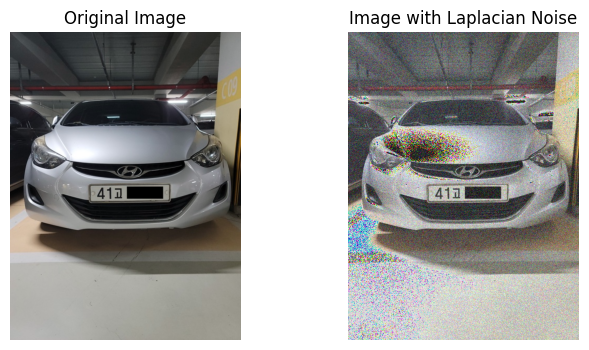

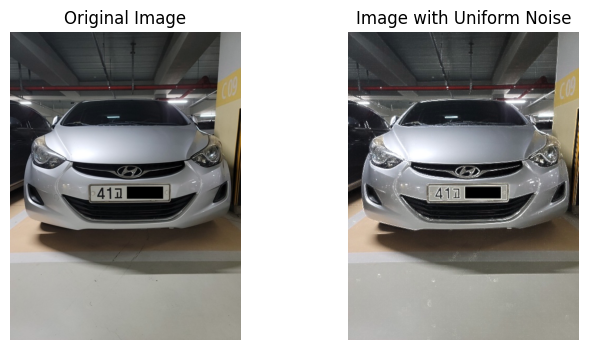

In [11]:
import matplotlib.pyplot as plt

# 원본 이미지와 노이즈가 적용된 이미지를 시각화하여 비교하는 함수
def visualize_image_with_noise(original_image, noisy_image, noise_type):
    plt.figure(figsize=(8, 4))
    # 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    # 노이즈가 적용된 이미지
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image)
    plt.title(f'Image with {noise_type} Noise')
    plt.axis('off')
    plt.show()

# 원본 이미지를 흑백으로 읽어옴
image = cv2.imread('../3.jpg')

# 노이즈가 적용된 이미지 생성
noisy_image_laplacian = uniform_noise(image)
noisy_image_uniform = laplacian_noise(image)

# 노이즈가 적용된 이미지 시각화
visualize_image_with_noise(image, noisy_image_laplacian, 'Laplacian')
visualize_image_with_noise(image, noisy_image_uniform, 'Uniform')